<a href="https://colab.research.google.com/github/anugyaparashar/Machine-Learning-Project/blob/main/TCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 2.8MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 47kB/s 
     |████████████████████████████████| 491kB 46.1MB/s 
     |████████████████████████████████| 3.2MB 44.3MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
# created the dictionary of the forms
d={}
from subprocess import check_output
with open('/content/gdrive/My Drive/forms_for_parsing.txt') as f:
  for line in f:
    key=line.split(' ')[0]
    writer=line.split(' ')[1]
    d[key]=writer
print(len(d.keys()))

1539


In [ ]:
#All imports 
from __future__ import division
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg

from keras.models import Sequential
from keras.layers import Dense , Dropout , Flatten , Lambda , ELU , Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D , Cropping2D ,ZeroPadding2D , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD , Adam , RMSprop
from google.colab import drive

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

(4920,)
(4920,)


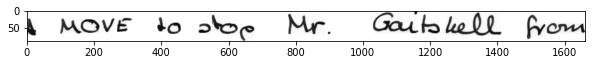

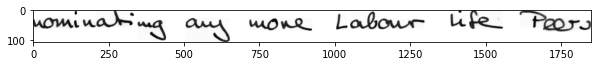

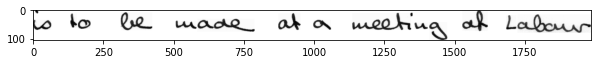

In [ ]:
# All file-names list and target-writer names list are created.
tmp = []
target_list = []

path_to_files = os.path.join('/content/gdrive/My Drive/data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
#     print(filename)
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

# visualize the image data
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')
    

In [ ]:
print(img_targets)

['000' '000' '000' ... '635' '635' '635']


In [ ]:
# Normalizing the data

lbl = LabelEncoder()
lbl.fit(img_targets)
enc_lbl = lbl.transform(img_targets)

print(img_files[:5] , img_targets[:5] , enc_lbl[:5])

['/content/gdrive/My Drive/data_subset/a01-000u-s00-00.png'
 '/content/gdrive/My Drive/data_subset/a01-000u-s00-01.png'
 '/content/gdrive/My Drive/data_subset/a01-000u-s00-02.png'
 '/content/gdrive/My Drive/data_subset/a01-000u-s00-03.png'
 '/content/gdrive/My Drive/data_subset/a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


In [ ]:
# SAMPLING THE DATA
# Splitting of data into training and validation sets for cross validation with 4:1:1 ratio.
train_files, rem_files, train_targets, rem_targets = train_test_split(img_files, enc_lbl, train_size=0.66, random_state=52, shuffle= True)
val_files, test_files, val_targets, test_targets = train_test_split(rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)


train_files = train_files[:3233]
train_targets = train_targets[:3233]
val_files = val_files[:833]
val_targets = val_targets[:833]
test_files = test_files[:833]
test_targets = test_targets[:833]

print(train_files.shape, val_files.shape, test_files.shape)
print(train_targets.shape, val_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


In [ ]:
# Generator function for generating random crops from each sentence randomly cropping 113*113 patches from images

batch_size = 16
num_classes = 700

def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)
            

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255
            
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train, y_train)


train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(val_files, val_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)


In [ ]:
# A Keras Model is built. Summary of the model is printed below.
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize(image,[56,56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image))  #resize images to allow for easy computation
#model.add(Lambda(lambda x: resize_image))

# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters=128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, name='dense1'))  #1024
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes
print("Worked till here")

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

print(model.summary())


Worked till here
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 

In [ ]:
# Training the Model
epochs = 1

steps_per_epoch = 233
validation_steps = 62


# #save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
filepath="gdrive/My Drive/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

# #Model fit generator
history_object = model.fit(train_generator, steps_per_epoch= steps_per_epoch,
                                      validation_data=validation_generator,
                                      validation_steps=validation_steps,
                            epochs=epochs, 
                           verbose=1,
                           callbacks=callbacks_list)



Epoch 1/1
233/233 [==============================] - 3816s 16s/step - loss: 4.0922 - accuracy: 0.1918 - val_loss: 3.6665 - val_accuracy: 0.2297

Epoch 00001: saving model to gdrive/My Drive/check-01-3.6665.hdf5


In [ ]:
"""### Performance Metrics
Let's now test our model for calculating accuracy.
"""
model.load_weights('gdrive/My Drive/check-01-3.5850.hdf5')
#model.load_weights('gdrive/My Drive/check-01-0.0000.hdf5')
#model.load_weights('gdrive/My Drive/check-02-0.0000.hdf5')
scores = model.evaluate_generator(test_generator,121) # 121 is the number of test images.
print("Accuracy = ", scores[1] , " ::" , len(scores))

Accuracy =  0.2393471747636795  :: 2


In [ ]:
images = []
for filename in test_files[:50]:
     im = Image.open(filename)

     cur_width = im.size[0]
     cur_height = im.size[1]

     print("Before Crop:", cur_width, cur_height)
     height_fac = 113 / cur_height

     new_width = int(cur_width * height_fac)
     size = new_width, 113

     imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
     now_width = imresize.size[0]
     now_height = imresize.size[1]
     print("After Crop:", now_width, now_height)
#     # Generate crops of size 113x113 from this resized image and keep random 10% of crops

     avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

#     # Pick random x%
     factor = 0.1
     pick_num = int(len(avail_x_points)*factor)
     print("Pick Number is ::", pick_num)
    
     random_startx = sample(avail_x_points,  pick_num)

     for start in random_startx:
         imcrop = imresize.crop((start, 0, start+113, 113))
         images.append(np.asarray(imcrop))
         
     X_test = np.array(images)
    
     X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
#     #convert to float and normalize
     X_test = X_test.astype('float32')
     X_test /= 255
     shuffle(X_test)

print(X_test.shape)

Before Crop: 1719 127
After Crop: 1529 113
Pick Number is :: 141
Before Crop: 556 166
After Crop: 378 113
Pick Number is :: 26
Before Crop: 1736 150
After Crop: 1307 113
Pick Number is :: 119
Before Crop: 1714 159
After Crop: 1218 113
Pick Number is :: 110
Before Crop: 184 66
After Crop: 315 113
Pick Number is :: 20
Before Crop: 230 140
After Crop: 185 113
Pick Number is :: 7
Before Crop: 329 115
After Crop: 323 113
Pick Number is :: 21
Before Crop: 1079 101
After Crop: 1207 113
Pick Number is :: 109
Before Crop: 1582 149
After Crop: 1199 113
Pick Number is :: 108
Before Crop: 1778 72
After Crop: 2790 113
Pick Number is :: 267
Before Crop: 522 72
After Crop: 819 113
Pick Number is :: 70
Before Crop: 1573 189
After Crop: 940 113
Pick Number is :: 82
Before Crop: 1917 176
After Crop: 1230 113
Pick Number is :: 111
Before Crop: 1986 140
After Crop: 1602 113
Pick Number is :: 148
Before Crop: 1620 155
After Crop: 1181 113
Pick Number is :: 106
Before Crop: 1658 104
After Crop: 1801 113
Pic

In [1]:
# Creating the predictive model

predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
     predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

writer_number = 0
total_image = 20
counter = 0

for i in range(len(predicted_writer)//10):
  if predicted_writer[i] == writer_number:
    image= X_test[i].squeeze()
    plt.figure(figsize=(2,2))
    plt.imshow(image, cmap='gray')
#print(X_test[1])
image1 = X_test[0].squeeze()
image2 = X_test[1].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image1, cmap = 'gray')

plt.figure(figsize=(2,2))
plt.imshow(image, cmap = 'gray')

NameError: ignored